<a href="https://colab.research.google.com/github/antonis00/EKPA/blob/main/IPS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_27 (Dense)            (None, 64)                1600      
                                                                 
 dense_28 (Dense)            (None, 64)                4160      
                                                                 
 dense_29 (Dense)            (None, 3)                 195       
                                                                 
Total params: 5955 (23.26 KB)
Trainable params: 5955 (23.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
38/38 [==============================] - 2s 8ms/step - loss: 1.1048 - accuracy: 0.3547 - val_loss: 1.0952 - val_accuracy: 0.3741
Epoch 2/100
38/38 [==============================] - 0s 4ms/step - loss: 1.0816 - accuracy: 0.4267 - val_loss: 1.0742 - val_accuracy: 0.4605
Ep

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


38/38 [==============================] - 0s 4ms/step - loss: 1.0625 - accuracy: 0.5206 - val_loss: 1.0542 - val_accuracy: 0.5754
Epoch 4/100
38/38 [==============================] - 0s 4ms/step - loss: 1.0443 - accuracy: 0.6009 - val_loss: 1.0365 - val_accuracy: 0.6367
Epoch 5/100
38/38 [==============================] - 0s 7ms/step - loss: 1.0274 - accuracy: 0.6354 - val_loss: 1.0201 - val_accuracy: 0.6572
Epoch 6/100
38/38 [==============================] - 0s 5ms/step - loss: 1.0111 - accuracy: 0.6548 - val_loss: 1.0032 - val_accuracy: 0.6772
Epoch 7/100
38/38 [==============================] - 0s 5ms/step - loss: 0.9941 - accuracy: 0.6634 - val_loss: 0.9862 - val_accuracy: 0.6923
Epoch 8/100
38/38 [==============================] - 0s 5ms/step - loss: 0.9772 - accuracy: 0.6877 - val_loss: 0.9687 - val_accuracy: 0.6939
Epoch 9/100
38/38 [==============================] - 0s 6ms/step - loss: 0.9593 - accuracy: 0.6957 - val_loss: 0.9494 - val_accuracy: 0.6944
Epoch 10/100
38/38 [=====

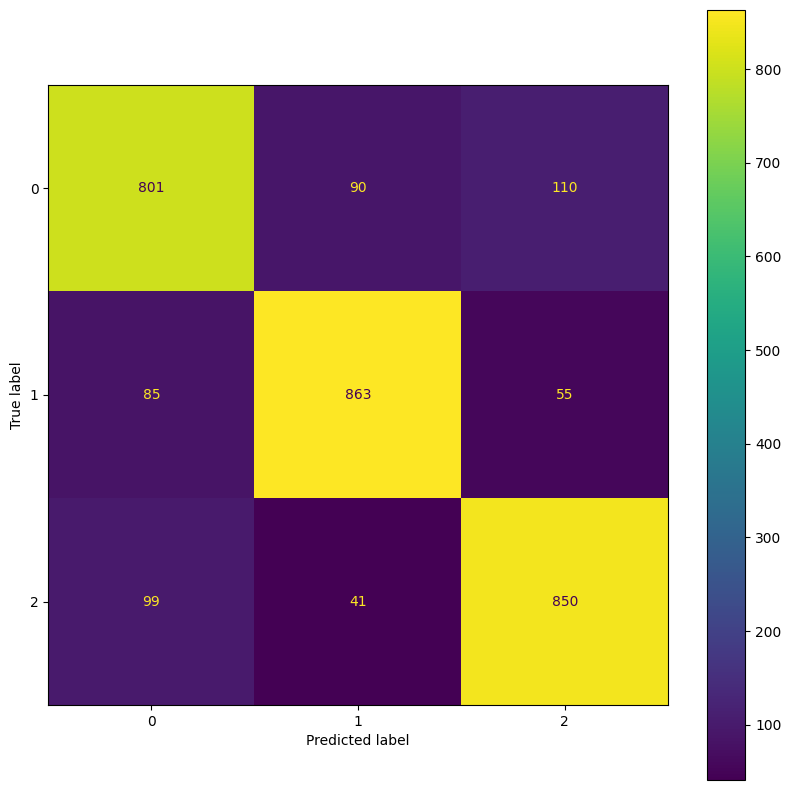

In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders
import datetime

# URL of the dataset
dataset_url = 'https://raw.githubusercontent.com/kdemertzis/EKPA/main/Data/pcap_data.csv'

def load_dataset(url):
    df = pd.read_csv(url)

    # Assuming the last column is the label and first column is an ID or similar identifier
    labels = df.iloc[:, -1]
    features = df.iloc[:, 1:-1]  # Adjusted to skip an identifier column if present

    # Normalize features
    features = (features - features.min()) / (features.max() - features.min())

    # Split the dataset
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size=0.20, random_state=42, stratify=labels)
    return df, train_features.values, train_labels.values, test_features.values, test_labels.values

# Load data
original_df, train_data, train_labels, test_data, test_labels = load_dataset(dataset_url)

# Convert labels to categorical indices
label_indices = pd.Series(train_labels).astype('category').cat.codes
nclass = len(np.unique(label_indices))
train_labels = to_categorical(label_indices, num_classes=nclass)

# Test labels also need conversion for use in metrics
test_label_indices = pd.Series(test_labels).astype('category').cat.codes
test_labels = to_categorical(test_label_indices, num_classes=nclass)

# Get number of features
inshape = train_data.shape[1]

# Define model (Example using a simple Dense network)
def create_model(input_shape, num_classes):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,)),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(inshape, nclass)
model.summary()

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, mode='min')
model_checkpoint = ModelCheckpoint('model_best.weights.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

# Training the model
history = model.fit(train_data, train_labels, epochs=100, batch_size=256, validation_split=0.2, callbacks=[early_stopping, model_checkpoint])

# Load the best model
model.load_weights('model_best.weights.hdf5')

# Predict the classes with the model
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_label_indices.values

# Generate the confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay(confusion_matrix=cm).plot(ax=ax)
plt.show()


In [19]:

# Filtering and saving anomalous records
anomalous_df = original_df.iloc[test_label_indices.index][predicted_classes != true_classes]
anomalous_df.to_csv('anomalous_traffic.csv', index=False)

def send_email(file_path, recipient_email):
    sender_email = "ips@test.com"
    sender_password = "your_password_here"  # You should use a more secure method in production

    # Create the email head (sender, receiver, and subject)
    email = MIMEMultipart()
    email['From'] = sender_email
    email['To'] = recipient_email
    email['Subject'] = f"{datetime.datetime.now().strftime('%Y-%m-%d')} IPS Report"

    # Attach the body with a simple text
    body = "Please find attached the IPS report for today."
    email.attach(MIMEText(body, 'plain'))

    # Attach the file
    attachment = open(file_path, "rb")
    part = MIMEBase('application', 'octet-stream')
    part.set_payload((attachment).read())
    encoders.encode_base64(part)
    part.add_header('Content-Disposition', "attachment; filename= %s" % file_path)
    email.attach(part)

    # Establish a secure session with Gmail's outgoing SMTP server using your email account
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(email['From'], sender_password)
    text = email.as_string()
    server.sendmail(email['From'], email['To'], text)
    server.quit()

send_email('anomalous_traffic.csv', 'admin@test.com')


NameError: name 'MIMEMultipart' is not defined

     Avg_syn_flag  Avg_urg_flag  Avg_fin_flag  Avg_ack_flag  Avg_psh_flag  \
0        1.114822      1.778551     -0.252938      1.063554     -0.834760   
1        0.332598      5.414916      0.155488      1.492508     -0.817481   
2        0.657407      2.391673     -1.541590     -0.001025     -2.127737   
3        6.098599      0.760628      1.113552     -1.540454      1.802576   
4       -0.931919      5.035000     -2.353868     -0.621855     -0.950649   
..            ...           ...           ...           ...           ...   
505      2.265713      3.445025      0.457264     -1.257937     -1.910571   
506     -1.963822      1.718783     -0.487478     -0.224094      1.380168   
507      2.491147     -5.209955     -0.747994     -0.682855     -0.527122   
508      4.220607      3.995391     -0.695200      1.293907      0.384131   
509     -0.848981      1.328334     -1.135886      0.944701      1.383368   

     Avg_rst_flag  Avg_DNS_pkt  Avg_TCP_pkt  Avg_UDP_pkt  Avg_ICMP_pkt  ...